In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/u/nlp/anaconda/main/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
PUSHSHIFT_OUTPUT_DIR = 'pushshift_output'
BACKGROUND_OUTPUT_DIR = 'pushshift_output_background'
PRAW_OUTPUT_DIR = 'praw_output'
POSTS_DIR = 'posts'
COMMENTS_DIR = 'post_comments'
OUTPUT_DIR = 'reddit_data'

In [22]:
lemmatized_background_corpus_df = pd.read_csv('reddit_data/background_corpus_lemmas.tsv',sep='\t',header=0)
lemmatized_background_corpus_df.shape

(2231878, 3)

# Posts

Gathering all the Pushshift (no PRAW yet) output and dropping duplicate posts, we have 1.4M posts total.

In [3]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(OUTPUT_DIR,POSTS_DIR,
                                                                   '*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_posts = pd.concat(pushshift_dfs,axis=0)

unique_posts = all_pushshift_posts.drop_duplicates('id',keep='first')
print('Number of unique posts:',len(unique_posts))

Number of unique posts: 1408681


In [4]:
del pushshift_dfs
del all_pushshift_posts

In [5]:
unique_posts.columns

Index(['id', 'title', 'url', 'author', 'score', 'date', 'num_comments',
       'permalink', 'flair', 'is_video', 'upvote_ratio', 'text', 'subreddit'],
      dtype='object')

Drop posts without text--no point keeping them. But all posts seem to have text, and 970k have titles.

In [7]:
unique_posts.title.apply(lambda x: type(x)).value_counts()

<class 'str'>         975950
<class 'NoneType'>    432731
Name: title, dtype: int64

In [8]:
unique_posts.loc[(unique_posts.title.apply(lambda x: isinstance(x,str)))].shape

(975950, 13)

In [9]:
unique_posts.text.apply(lambda x: type(x)).value_counts()

<class 'str'>    1408681
Name: text, dtype: int64

In [10]:
unique_posts.loc[(unique_posts.text.apply(lambda x: isinstance(x,str)))].shape

(1408681, 13)

In [6]:
posts_with_text = unique_posts.loc[(unique_posts.title.apply(lambda x: isinstance(x,str))) |
                                           (unique_posts.text.apply(lambda x: isinstance(x,str)))].copy()
print(posts_with_text.shape)
del unique_posts

(1408681, 13)


But which of these have non-zero num words?

In [7]:
posts_with_text['title_num_words'] = posts_with_text.title.apply(lambda x: len(x.split()) 
                                                                 if x is not None else 0)

In [8]:
posts_with_text['body_num_words'] = posts_with_text.text.apply(lambda x: len(x.split()))

So 976k posts have title w/ non-zero words; 235k have body w/ non-zero words. 

In [13]:
print(posts_with_text.loc[posts_with_text['title_num_words'] > 0].shape,
      posts_with_text.loc[posts_with_text['body_num_words'] > 0].shape)

(975950, 15) (235371, 15)


Combined, there are 976k posts with >0 num words in either title or body.

In [10]:
posts_with_text.loc[(posts_with_text.title_num_words > 0) |
                   (posts_with_text.body_num_words > 0)].shape

(975950, 15)

We'll keep only these posts. The ones with 0 words don't have any comments anyways:

In [13]:
#posts_with_text.loc[posts_with_text['total_num_words'] == 0].num_comments.value_counts()

In [9]:
posts_with_text['total_num_words'] = posts_with_text['title_num_words'] + \
posts_with_text['body_num_words']
posts_with_words = posts_with_text.loc[posts_with_text.total_num_words > 0]
print(posts_with_words.shape)
del posts_with_text

(975950, 16)


In [11]:
posts_with_words.to_pickle('reddit_data/posts_with_words.pkl')

Now we are ready to start exploring the stats of the posts with words!

In [10]:
# Add column for parsed date
posts_with_words['parsed_date'] = posts_with_words.date.apply(lambda x: datetime.utcfromtimestamp(x) 
                                                            if not pd.isnull(x)
                                                     and type(x) == float else x)
# Extract month, year
posts_with_words['year'] = posts_with_words.parsed_date.apply(lambda x: x.year if not pd.isnull(x)
                                                     else None)
# posts_with_words['month'] = posts_with_words.parsed_date.apply(lambda x: x.month if not pd.isnull(x)
#                                                      else None)

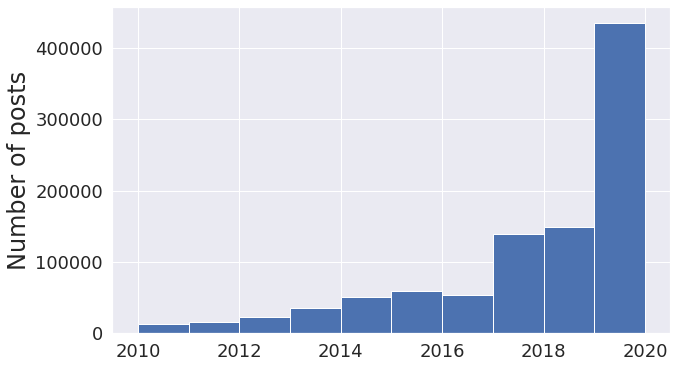

In [27]:
ax = posts_with_words['year'].plot.hist(figsize=(10,6))
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

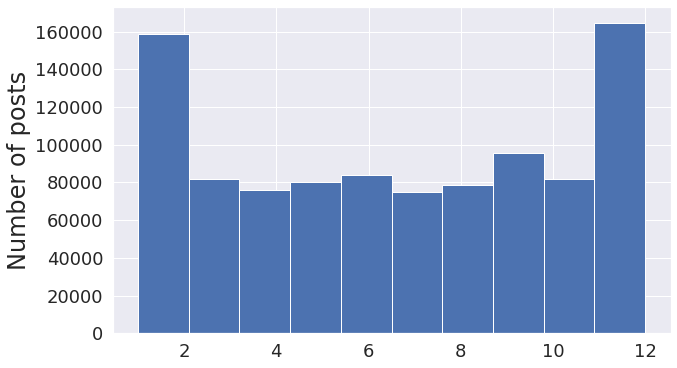

In [28]:
ax = posts_with_words['month'].plot.hist(figsize=(10,6))
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

"Flair":

In [30]:
list(posts_with_words.flair.value_counts().index)[:30]

['NaN',
 'Environment',
 'Earth Sciences',
 'Discussion',
 'Question',
 'Energy',
 'Selling',
 'News',
 'Chemistry',
 '',
 '[ futurology ]',
 'politics',
 'Biology',
 'Auto Crosspost',
 'Climate',
 'Writing Prompt',
 'Other',
 'serious replies only',
 'Politics',
 'submission-worldnews',
 'Already Submitted',
 'Xbox',
 'Planetary Sci.',
 '[ worldnews ]',
 'Buying',
 'politics|pnewell',
 'PS4',
 'Serious Replies Only',
 'Help/Advice',
 'article']

There are 2.5k video posts:

In [31]:
posts_with_words.is_video.value_counts()

False    687881
True       2503
Name: is_video, dtype: int64

Let's examine the X and Y variables, starting with X (text).

Let's plot the number of words in title/body:

The distribution of #words in post titles. There are 0 posts with no words in the title.

In [43]:
len(posts_with_words['title_num_words'].loc[posts_with_words['title_num_words'] == 0])

0

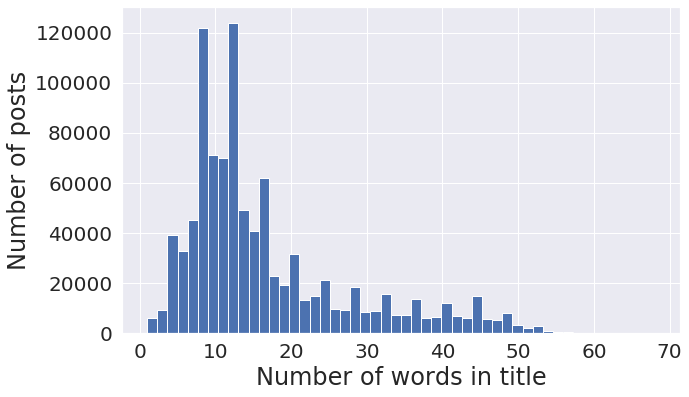

In [44]:
ax = posts_with_words['title_num_words'].loc[posts_with_words['title_num_words'] > 0].plot.hist(bins=50,figsize=(10,6))
ax.set_xlabel("Number of words in title",fontsize=24)
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

Same, but for #words in the post body. There are 741k posts (out of 1.4M total) without words in the body.

In [47]:
len(posts_with_words['body_num_words'].loc[posts_with_words['body_num_words'] == 0])

740579

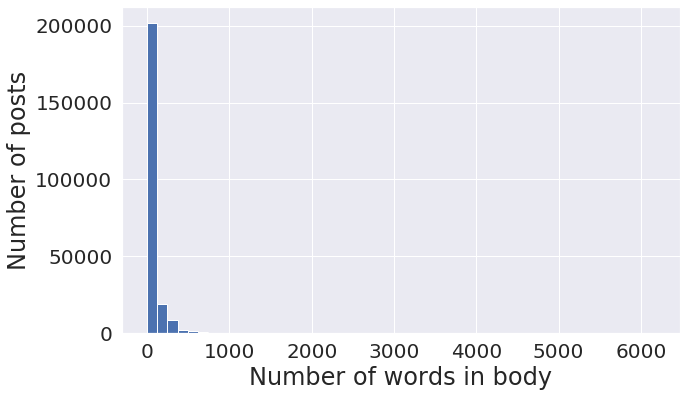

In [48]:
ax = posts_with_words.loc[posts_with_words['body_num_words'] > 0]['body_num_words'].plot.hist(bins=50,figsize=(10,6))
ax.set_xlabel("Number of words in body",fontsize=24)
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

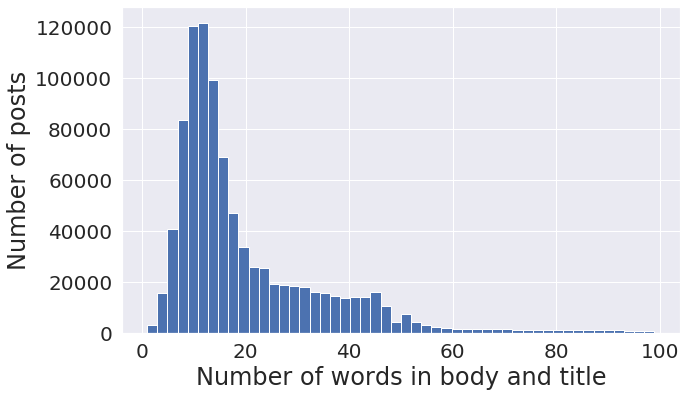

In [51]:
# Combined distribution
ax = posts_with_words.loc[(posts_with_words['total_num_words'] > 0) &
                         (posts_with_words['total_num_words'] < 100)]['total_num_words'].plot.hist(bins=50,figsize=(10,6))
ax.set_xlabel("Number of words in body and title",fontsize=24)
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

Now let's examine the Y variables. All posts have a score; only 36k have an upvote ratio; all have length of comment thread (but only 430k have non-zero num comments). 

In [52]:
# Reminder: number datapoints with X
posts_with_words.loc[(posts_with_words['total_num_words'] > 0)].shape

(975950, 19)

In [53]:
print(posts_with_words.loc[~pd.isnull(posts_with_words.score)].shape,
posts_with_words.loc[~pd.isnull(posts_with_words.num_comments)].shape,
posts_with_words.loc[~pd.isnull(posts_with_words.upvote_ratio)].shape)

(975950, 19) (975950, 19) (36288, 19)


In [54]:
posts_with_words.loc[~pd.isnull(posts_with_words.num_comments) &
                    posts_with_words.num_comments > 0].shape

(431142, 19)

We want both text and an outcome for using Reid's model. We can use either the title text, or title text and body text, as X and have the same size of X.

* X = text (title, or both title and body), N = 975,950
* Y = upvote ratio, N = 36,288
* Y = score, N = 975,950

We also have confound variables, C. Let's examine which of these are missing from the potential X, Y: author, date, is_video, subreddit.

Other than whether or not a post is a video, most posts have all 4 attributes.

In [56]:
print(
    posts_with_words.loc[~pd.isnull(posts_with_words.author)].shape,
    posts_with_words.loc[~pd.isnull(posts_with_words.date)].shape,
    posts_with_words.loc[~pd.isnull(posts_with_words.is_video)].shape,
    posts_with_words.loc[~pd.isnull(posts_with_words.subreddit)].shape
)

(975733, 19) (975950, 19) (690384, 19) (975743, 19)


Let's examine the distribution of scores, upvote_ratio.

In [57]:
posts_with_upvr = posts_with_words.loc[(~pd.isnull(posts_with_words.upvote_ratio))]

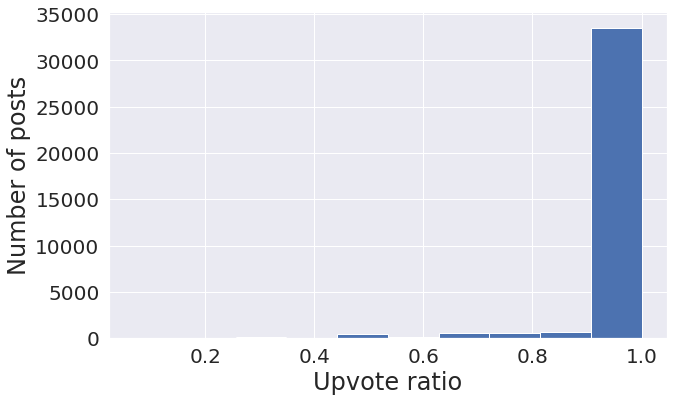

In [60]:
ax = posts_with_upvr.upvote_ratio.plot.hist(bins=10,figsize=(10,6)) 
ax.set_ylabel("Number of posts",fontsize=24)
ax.set_xlabel("Upvote ratio",fontsize=24)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)

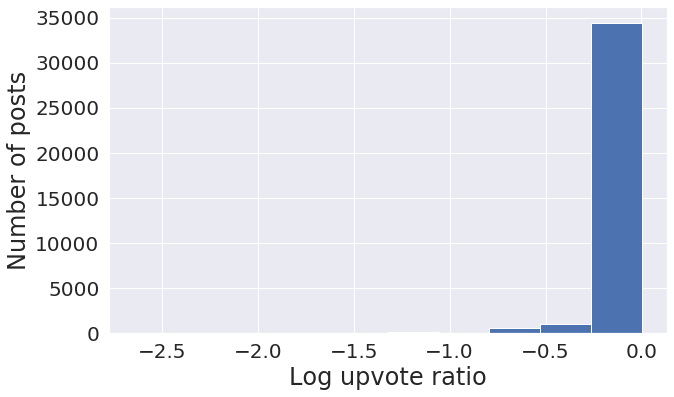

In [61]:
log_upvr = pd.Series(posts_with_upvr.upvote_ratio+0.001).apply(lambda x: np.log(x))
ax = log_upvr.plot.hist(bins=10,figsize=(10,6)) 
ax.set_ylabel("Number of posts",fontsize=24)
ax.set_xlabel("Log upvote ratio",fontsize=24)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)

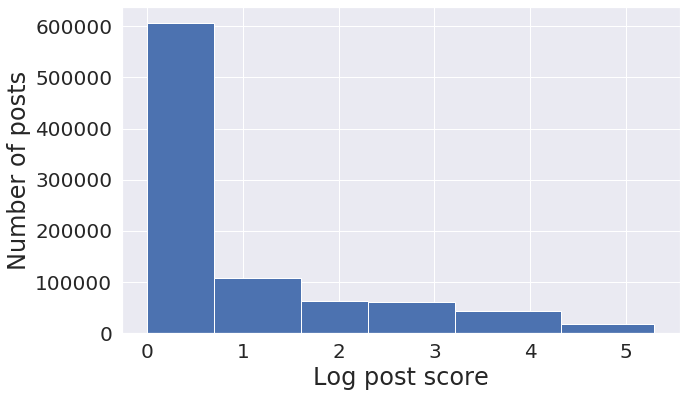

In [59]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(np.log(posts_with_words.loc[(~pd.isnull(posts_with_words.score))].score+0.001),
bins=np.log([1, 2, 5, 10, 25, 75, 200]),histtype='bar')#,ax=ax)
ax.set_xlabel("Log post score",fontsize=24)
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)

Finally, let's examine stats on subreddits and redditors/users/authors.

We have representation from 31k subreddits and 248k users.

In [16]:
print(len(posts_with_words.loc[~pd.isnull(posts_with_words.subreddit)].subreddit.value_counts()),
      len(posts_with_words.loc[~pd.isnull(posts_with_words.author)].author.value_counts()))

31342 248377


Distribution of posts written by users.

In [63]:
nan_authors = set(['[deleted]','-1',-1,'-en-'])

In [65]:
posts_with_authors = posts_with_words.loc[~posts_with_words.author.isin(nan_authors)]

In [68]:
posts_per_author = posts_with_authors.author.value_counts()#.index)
posts_per_author

EcoInternetNewsfeed    58696
itchyyyyscrotum        34070
BirdieBroBot           26187
AutoNewsAdmin          23132
AutoNewspaperAdmin     21686
                       ...  
Decklan_R                  1
beer_down                  1
US_of_Alaska               1
soccer_trekkie             1
JorvikViking               1
Name: author, Length: 248375, dtype: int64

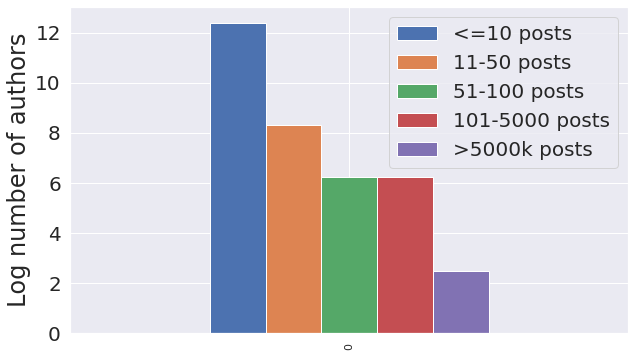

In [69]:
df_ = pd.DataFrame({
    '<=10 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 10])),
    '11-50 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 50 and 
                             posts_per_author[a] > 10])),
    '51-100 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 100 and 
                             posts_per_author[a] > 50])),
    '101-5000 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 5000 and 
                               posts_per_author[a] > 100])),
    '>5000k posts':np.log(len([a for a in posts_per_author.index if  
                               posts_per_author[a] > 5000]))
},index=[0])
ax = df_.plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Log number of authors",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

Distribution of subreddits posted in by users.

In [70]:
df_a = posts_with_authors.drop_duplicates(['author', 'subreddit'])
df_a.groupby('author').size()

author
--------__--------    1
------_-_-_-_-_       1
------_________       1
------w               1
-----E-----           1
                     ..
zzzogas413            1
zzzpt                 1
zzzquiled             1
zzzzippy              4
zzzzz1233             1
Length: 248375, dtype: int64

In [71]:
subreddits_per_author = df_a.groupby('author').size()

In [72]:
subreddits_per_author['zzzzippy']

4

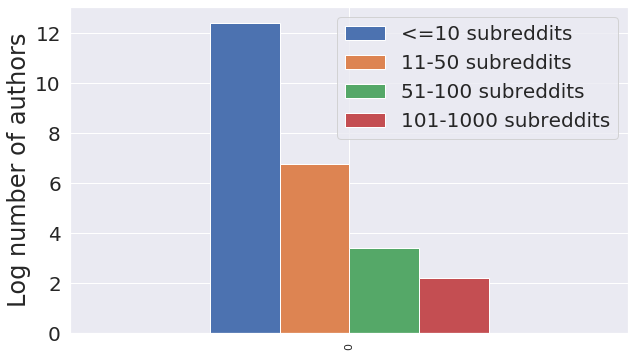

In [74]:
df_ = pd.DataFrame({
    '<=10 subreddits':np.log(len([a for a in subreddits_per_author.index
                                  if subreddits_per_author[a] <= 10])),
    '11-50 subreddits':np.log(len([a for a in subreddits_per_author.index
                                   if subreddits_per_author[a] <= 50 and 
                             subreddits_per_author[a] > 10])),
    '51-100 subreddits':np.log(len([a for a in subreddits_per_author.index
                                    if subreddits_per_author[a] <= 100 and 
                             subreddits_per_author[a] > 50])),
    '101-1000 subreddits':np.log(len([a for a in subreddits_per_author.index
                                      if subreddits_per_author[a] <= 1000 and 
                               subreddits_per_author[a] > 100]))
},index=[0])
ax = df_.plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Log number of authors",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

Number of comments generated by a post:

In [76]:
comments_per_post = posts_with_words.loc[~pd.isnull(posts_with_words.num_comments)].\
num_comments.value_counts()

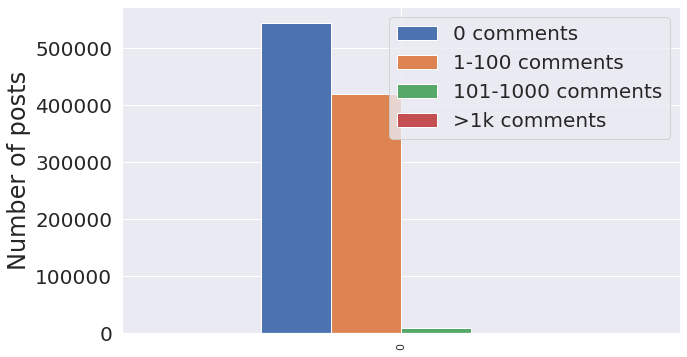

In [81]:
ax = pd.DataFrame({
    '0 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n == 0.0]),
    '1-100 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n > 0.0 and n <= 100.0]),
    '101-1000 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n > 100.0 and n <= 1000.0]),
    '>1k comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n > 1000.0])
},index=[0]).plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

In [83]:
# Unique commenters only

# Drop duplicate authors
unique_auth_comments_per_post = posts_with_words.loc[~pd.isnull(
    posts_with_words.num_comments)].drop_duplicates('author',keep='first').\
num_comments.value_counts()

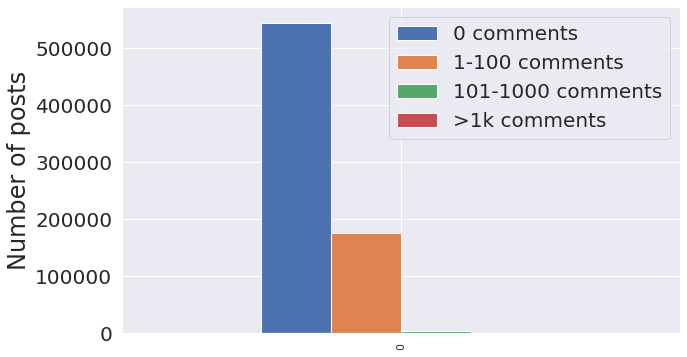

In [84]:
# Unique commenters only
ax = pd.DataFrame({
    '0 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n == 0.0]),
    '1-100 comments':np.sum([unique_auth_comments_per_post[n] 
                             for n in unique_auth_comments_per_post.index if n > 0.0 and n <= 100.0]),
    '101-1000 comments':np.sum([unique_auth_comments_per_post[n] 
                                for n in unique_auth_comments_per_post.index if n > 100.0 and n <= 1000.0]),
    '>1k comments':np.sum([unique_auth_comments_per_post[n] 
                           for n in unique_auth_comments_per_post.index if n > 1000.0])
},index=[0]).plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

# Comments

We have 8M unique comments from Pushshift (no PRAW):

In [12]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(OUTPUT_DIR,
                                                                   COMMENTS_DIR,'*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_comments = pd.concat(pushshift_dfs,axis=0)
del pushshift_dfs
unique_comments = all_pushshift_comments.drop_duplicates('id',keep='first')
del all_pushshift_comments

print('Number of unique comments:',len(unique_comments))

Number of unique comments: 8119184


In [13]:
# Drop comments without text or missing other fields

comments_with_text = unique_comments.loc[(unique_comments.text.apply(lambda x: isinstance(x,str)))]
del unique_comments
print('Dropping comments without text, new shape:',comments_with_text.shape)

comments_with_text['num_words'] = comments_with_text['text'].apply(lambda x: len(x.split()))
comments_with_words = comments_with_text.loc[comments_with_text['num_words'] > 0]
del comments_with_text
print('Dropping comments with 0 words, new shape:',comments_with_words.shape)

comments_with_words_complete = comments_with_words.loc[~pd.isnull(comments_with_words.date) &
                                                      ~pd.isnull(comments_with_words.subreddit) &
                                                      ~pd.isnull(comments_with_words.score) &
                                                      ~pd.isnull(comments_with_words.author)]
print('Dropping comments that are missing fields:',comments_with_words_complete.shape)
del comments_with_words

Dropping comments without text, new shape: (8119184, 7)
Dropping comments with 0 words, new shape: (8119184, 8)
Dropping comments that are missing fields: (8119160, 8)


In [5]:
#counted_subreddits = comments_with_words_complete.subreddit.value_counts()

In [6]:
#sorted(counted_subreddits.items(),key=lambda x: x[1],reverse=True)

In [18]:
comments_with_words_complete.author.value_counts()

[deleted]         127765
autotldr           18248
ILikeNeurons       13665
AutoModerator      10569
archiesteel         8416
                   ...  
_Nyarlethotep_         1
hey95                  1
bradd_91               1
MyUserName-exe         1
codasign               1
Name: author, Length: 1905005, dtype: int64

In [14]:
bad_authors = set(['[deleted]','-1',-1])

In [16]:
comments_with_words_authors_complete = comments_with_words_complete.loc[
    ~comments_with_words_complete.author.isin(bad_authors)]
print('Dropping comments with bad authors, new shape:',comments_with_words_authors_complete.shape)
del comments_with_words_complete

Dropping comments with bad authors, new shape: (7991395, 8)


In [17]:
comments_with_words_authors_complete['parsed_date'] = comments_with_words_authors_complete.date.apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isnull(x)
                                                     and type(x) == float else x)
# Extract month, year
comments_with_words_authors_complete['year'] = comments_with_words_authors_complete.parsed_date.apply(lambda x: x.year if not 
                                                           pd.isnull(x) else None)
# unique_comments['month'] = unique_comments.parsed_date.apply(lambda x: x.month if not 
#                                                            pd.isnull(x) else None)

In [18]:
comments_with_words_authors_complete.to_pickle('reddit_data/comments_complete.pkl')

We have representation from 1.9M users and 40k subreddits.

In [23]:
print(len(comments_with_words_authors_complete.author.value_counts()),
len(comments_with_words_authors_complete.subreddit.value_counts()))

1905004 40205


When we combine with posts, we have representation from 56k users and 2M subreddits.

In [25]:
print(len(set(posts_with_words.loc[~pd.isnull(posts_with_words.subreddit)].\
          subreddit.value_counts().index) | \
      set(comments_with_words_authors_complete.\
          subreddit.value_counts().index)),
      len(set(posts_with_words.loc[~pd.isnull(posts_with_words.author)].\
          author.value_counts().index) | \
          set(comments_with_words_authors_complete.\
          author.value_counts().index)))

56369 2028613


## Explore distribution of each attribute 

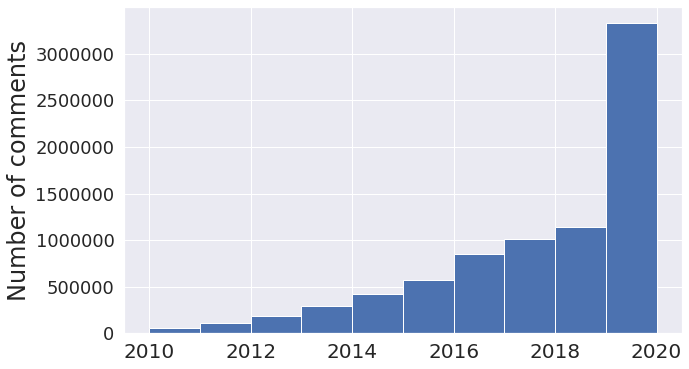

In [26]:
%matplotlib inline
ax = comments_with_words_authors_complete['year'].apply(lambda x: int(x)).plot.hist(bins=10,figsize=(10,6))
ax.set_ylabel('Number of comments',fontsize=24)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=18)

Main X, Y for model (text and engagement signals):

Distribution of #words in comments: 

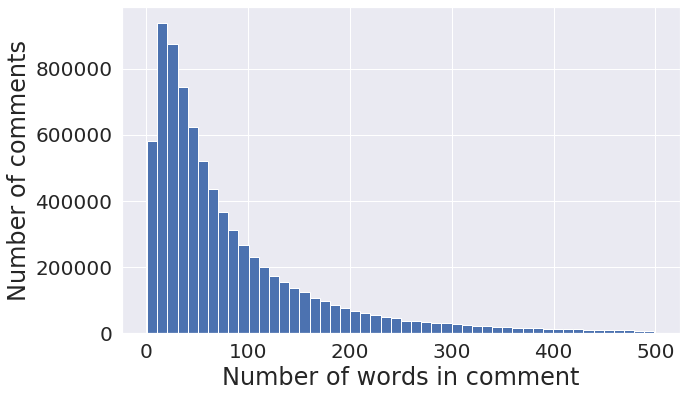

In [27]:
ax = comments_with_words_authors_complete.loc[
                         (comments_with_words_authors_complete['num_words'] < 500)]['num_words'].plot.hist(bins=50,figsize=(10,6))
ax.set_xlabel("Number of words in comment",fontsize=24)
ax.set_ylabel("Number of comments",fontsize=24)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

Most comments only have score as an engagement metric:

In [28]:
print(comments_with_words_authors_complete.loc[~pd.isnull(
    comments_with_words_authors_complete.score)].shape)

(7991395, 10)


The distribution of comment scores is

/u/nlp/anaconda/main/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


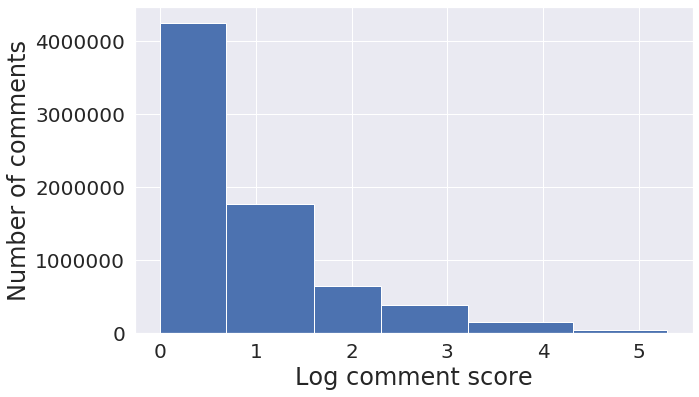

In [29]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(np.log(comments_with_words_authors_complete.score+0.001),
bins=np.log([1, 2, 5, 10, 25, 75, 200]),histtype='bar')#,ax=ax)
ax.set_xlabel("Log comment score",fontsize=24)
ax.set_ylabel("Number of comments",fontsize=24)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)

Number of comments written by each author

In [30]:
comments_per_author = comments_with_words_authors_complete.groupby('author').size()

In [31]:
comments_per_author# = comments_with_words_authors_complete.author.value_counts()

author
---                      2
------------------f      1
------------------oh     1
-----------_---          3
----------_----          1
                        ..
zzzzzzp                  4
zzzzzzzxxxxxxxxx         1
zzzzzzzz414             23
zzzzzzzzzzzzzip          1
zzzzzzzzzzzzzzzzspaf    17
Length: 1905004, dtype: int64

In [32]:
comments_per_author['zzzzzzzz414']

23

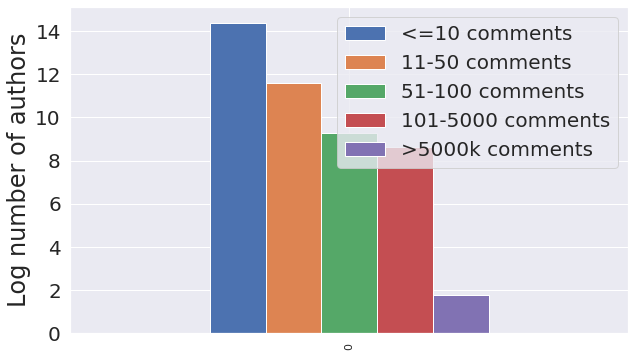

In [33]:
df_ = pd.DataFrame({
    '<=10 comments':np.log(len([a for a in comments_per_author.index if comments_per_author[a] <= 10])),
    '11-50 comments':np.log(len([a for a in comments_per_author.index if comments_per_author[a] <= 50 and 
                             comments_per_author[a] > 10])),
    '51-100 comments':np.log(len([a for a in comments_per_author.index if comments_per_author[a] <= 100 and 
                             comments_per_author[a] > 50])),
    '101-5000 comments':np.log(len([a for a in comments_per_author.index if comments_per_author[a] <= 5000 and 
                               comments_per_author[a] > 100])),
    '>5000k comments':np.log(len([a for a in comments_per_author.index if  
                               comments_per_author[a] > 5000]))
},index=[0])
ax = df_.plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Log number of authors",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

In [34]:
len([a for a in comments_per_author.index if comments_per_author[a] <= 500])

1904668

In [35]:
del comments_per_author

Number of subreddits commented in per author

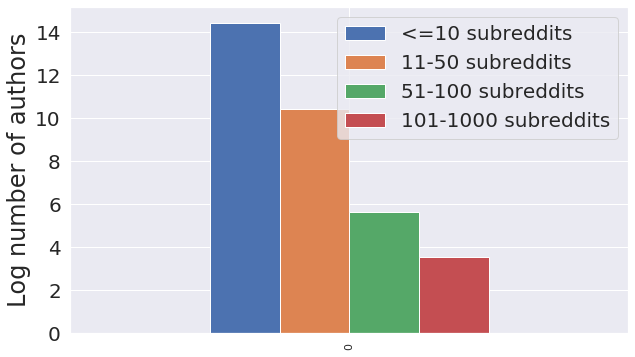

In [49]:
df_a = comments_with_words_authors_complete.drop_duplicates(['author', 'subreddit'])
subreddits_commented_per_author = df_a.groupby('author').size()

df_ = pd.DataFrame({
    '<=10 subreddits':np.log(len([a for a in subreddits_commented_per_author.index
                                  if subreddits_commented_per_author[a] <= 10])),
    '11-50 subreddits':np.log(len([a for a in subreddits_commented_per_author.index
                                   if subreddits_commented_per_author[a] <= 50 and 
                             subreddits_commented_per_author[a] > 10])),
    '51-100 subreddits':np.log(len([a for a in subreddits_commented_per_author .index
                                    if subreddits_commented_per_author[a] <= 100 and 
                             subreddits_commented_per_author[a] > 50])),
    '101-1000 subreddits':np.log(len([a for a in subreddits_commented_per_author.index
                                      if subreddits_commented_per_author[a] <= 1000 and 
                               subreddits_commented_per_author[a] > 100]))
},index=[0])
ax = df_.plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Log number of authors",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

In [51]:
len([a for a in subreddits_commented_per_author.index
                                  if subreddits_commented_per_author[a] <= 100])

1904965

# Posts and comments

Combining posts and comments, we have 44k unique subreddits and 1M unique users.

In [180]:
print(len(set(unique_comments.subreddit) | set(unique_posts.subreddit)),
      len(set(unique_comments.author) | set(unique_posts.author)))

43966 1148762


In [182]:
len(unique_comments)

3605917

In [183]:
len(unique_posts)

1271538

Most common subreddits:

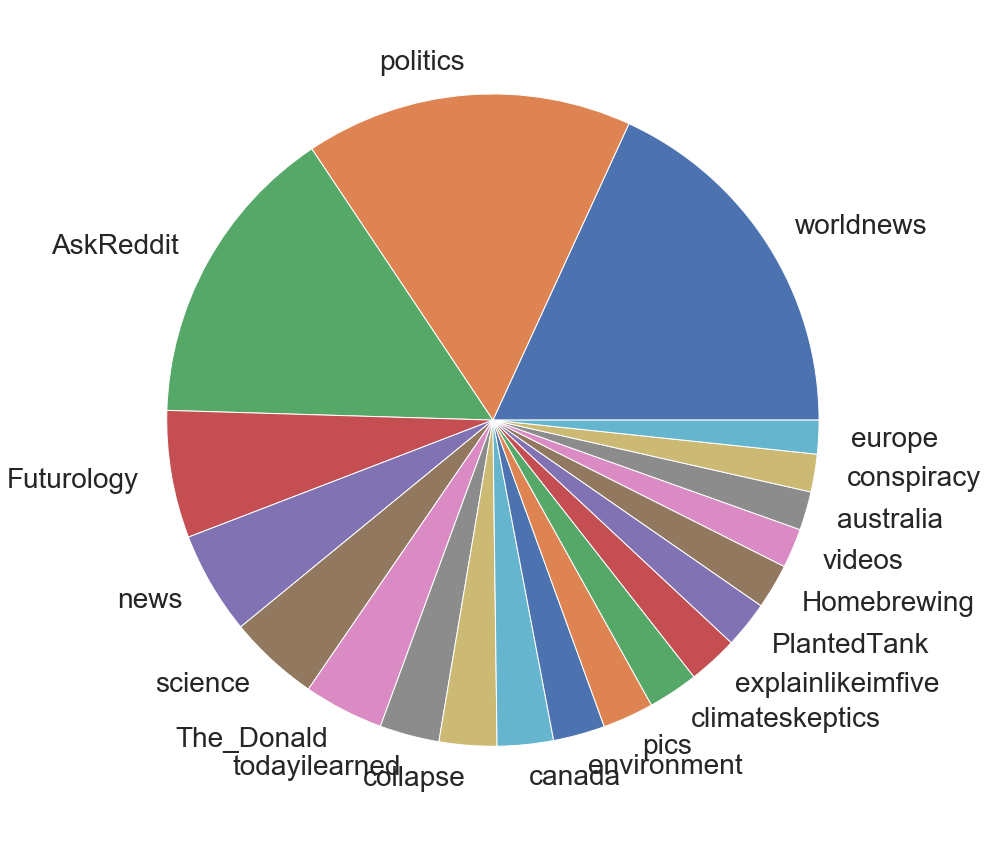

In [413]:
unique_comments['subreddit'].value_counts()[:20].plot.pie(figsize=(15, 15),label='',textprops={'fontsize': 28})

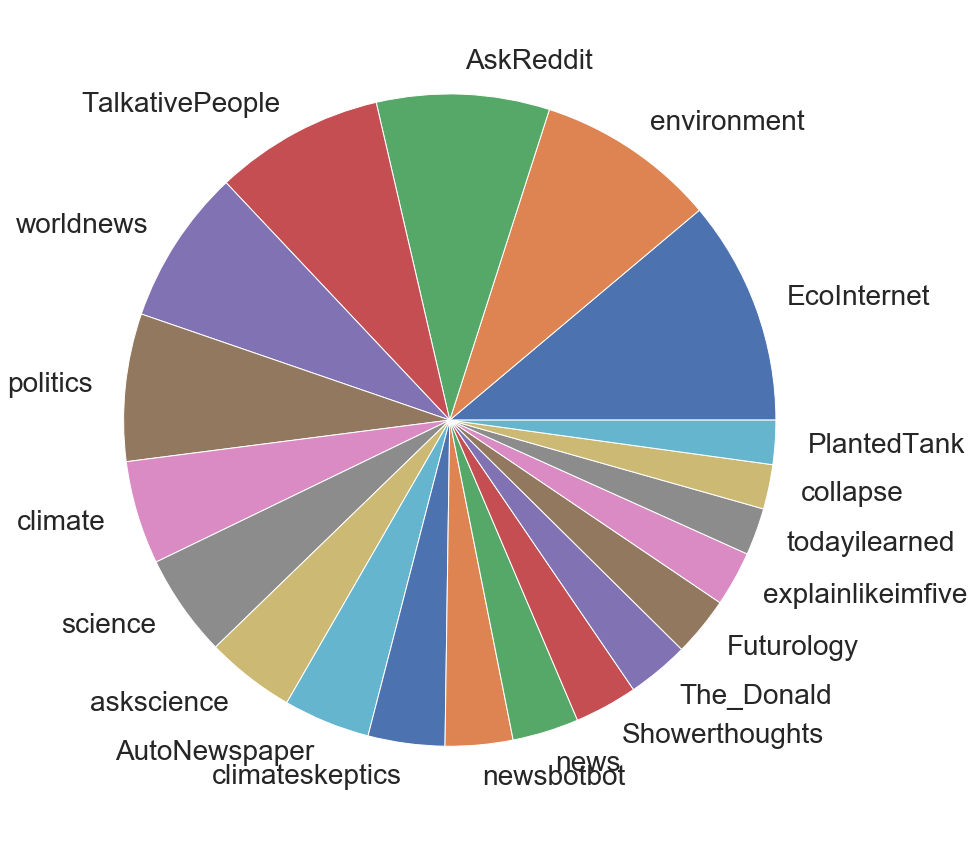

In [412]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0
ax = unique_posts['subreddit'].value_counts()[:20].plot.pie(figsize=(15, 15),label='',
                                                           textprops={'fontsize': 28})

In [89]:
# Posts with a single word in the body text
posts_with_text.loc[posts_with_text.text.apply(lambda x: len(x.split()) == 1)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
26,Do you agree with -- and/or can you explain wh...,WentzToDJax,1.594729e+09,False,hqulpf,0.0,2.0,0.63,9.0,2.0,https://www.minnpost.com/eric-black-ink/2013/0...,askaconservative,2020-07-14 12:08:34,2020.0,7.0
161,What do you think about bayonets being issued ...,Lavaknight368,1.593848e+09,False,hktcbx,0.0,3.0,1.00,21.0,3.0,https://thehill.com/policy/defense/505717-mill...,askaconservative,2020-07-04 07:32:46,2020.0,7.0
311,How likely is Trump to win (%)?,renaissance_pancakes,1.592994e+09,False,hesd7h,0.0,5.0,0.70,23.0,5.0,Go.,askaconservative,2020-06-24 10:20:14,2020.0,6.0
507,Are there any good conservative historians who...,ActualStreet,1.592009e+09,False,h7o8lv,0.0,6.0,0.88,3.0,6.0,Thanks,askaconservative,2020-06-13 00:42:35,2020.0,6.0
627,What should happen to Kayleigh McEnany if she ...,fizzywater42,1.591473e+09,False,gxpnui,0.0,17.0,0.80,11.0,17.0,https://www.huffpost.com/entry/trump-maralago-...,askaconservative,2020-06-06 19:56:19,2020.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Alex O'Connor (A.K.A. Cosmic Skeptic) is curre...,Omnibeneviolent,1.594266e+09,False,hnntvy,0.0,10.0,0.72,0.0,10.0,https://www.reddit.com/r/vegan/comments/hnmyk0...,skeptic,2020-07-09 03:36:18,2020.0,7.0
167,I love science guys!,AmazingPineaple6,1.593731e+09,False,hjyncq,0.0,0.0,0.10,0.0,0.0,https://encrypted-tbn0.gstatic.com/images?q=tb...,skeptic,2020-07-02 23:04:38,2020.0,7.0
490,Virus man-made according to Norwegian researcher,oli_gendebien,1.591601e+09,False,gyn7bl,0.0,0.0,0.25,9.0,0.0,https://www.forbes.com/sites/davidnikel/2020/0...,skeptic,2020-06-08 07:23:49,2020.0,6.0
1,A new nature economy could generate up to $10....,clim8pablo,1.594849e+09,False,hrnlof,0.0,11.0,1.00,0.0,11.0,[https://www.weforum.org/reports/new-nature-ec...,sustainability,2020-07-15 21:31:58,2020.0,7.0


# Background corpus

In [13]:
old_posts_with_words = pd.read_pickle('reddit_data/background_corpus_posts_with_words.pkl')
old_posts_with_words.shape

(6814407, 16)

In [4]:
old_posts_with_words['parsed_date'] = old_posts_with_words.date.apply(lambda x: datetime.utcfromtimestamp(x) 
                                                            if not pd.isnull(x)
                                                     and type(x) == float else x)
old_posts_with_words['year'] = old_posts_with_words.parsed_date.apply(lambda x: x.year if not pd.isnull(x)
                                                     else None)

In [5]:
old_posts_with_words['year'].value_counts()

2012    6245504
2011    3191980
2010    1427626
Name: year, dtype: int64

In [7]:
glob.glob(os.path.join(OUTPUT_DIR,BACKGROUND_OUTPUT_DIR,'1-1-2013*','*.pkl'))

['reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/europe.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/newsbotbot.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/askscience.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/climatechange.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/environment.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/space.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/collapse.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/PoliticalDiscussion.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/science.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/climateskeptics.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/AutoNewspaper.pkl',
 'reddit_data/pushshift_output_background/1-1-2013_to_12-31-2013/PlantedTank.pkl',
 'reddit

In [8]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(OUTPUT_DIR,BACKGROUND_OUTPUT_DIR,
                                                                   '1-1-2013*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_posts = pd.concat(pushshift_dfs,axis=0)

unique_posts = all_pushshift_posts.drop_duplicates('id',keep='first')
print('Number of new unique posts in background corpus:',len(unique_posts))

Number of new unique posts in background corpus: 6814407


In [9]:
del pushshift_dfs
del all_pushshift_posts

Drop background corpus posts without text:

In [10]:
posts_with_text = unique_posts.loc[(unique_posts.title.apply(lambda x: isinstance(x,str))) |
                                           (unique_posts.text.apply(lambda x: isinstance(x,str)))].copy()
print(posts_with_text.shape)
del unique_posts

(6814407, 13)


And we also keep only the posts with words in title or body:

In [11]:
posts_with_text['title_num_words'] = posts_with_text.title.apply(lambda x: len(x.split()) 
                                                                 if x is not None else 0)
posts_with_text['body_num_words'] = posts_with_text.text.apply(lambda x: len(x.split()))
posts_with_text['total_num_words'] = posts_with_text['title_num_words'] + \
posts_with_text['body_num_words']
posts_with_words = posts_with_text.loc[posts_with_text.total_num_words > 0]
print('Shape of new posts df:',posts_with_words.shape)

Shape of new posts df: (6814407, 16)


Combine and dedup from existing posts:

In [12]:
print('Adding to existing posts...')
posts_with_words = pd.concat([posts_with_words,old_posts_with_words],axis=0)
print('New shape:',posts_with_words.shape)

print('Deduplicating by post_id...')
posts_with_words = posts_with_words.drop_duplicates('id',keep='first')
print('New shape:',posts_with_words.shape)

Adding to existing posts...
New shape: (17110614, 16)
Deduplicating by post_id...
New shape: (10865110, 16)


In [12]:
print('Saving all posts...')
posts_with_words.to_pickle('reddit_data/background_corpus_posts_with_words.pkl')
print('Done!')
del posts_with_text

Saving all posts...
Done!


Examine distributions of #words, over subreddits:

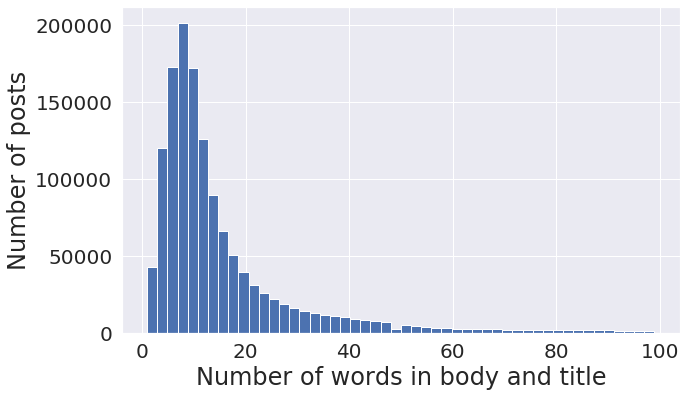

In [14]:
# Combined title + body words distribution
ax = posts_with_words.loc[(posts_with_words['total_num_words'] > 0) &
                         (posts_with_words['total_num_words'] < 100)]['total_num_words'].plot.hist(bins=50,figsize=(10,6))
ax.set_xlabel("Number of words in body and title",fontsize=24)
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

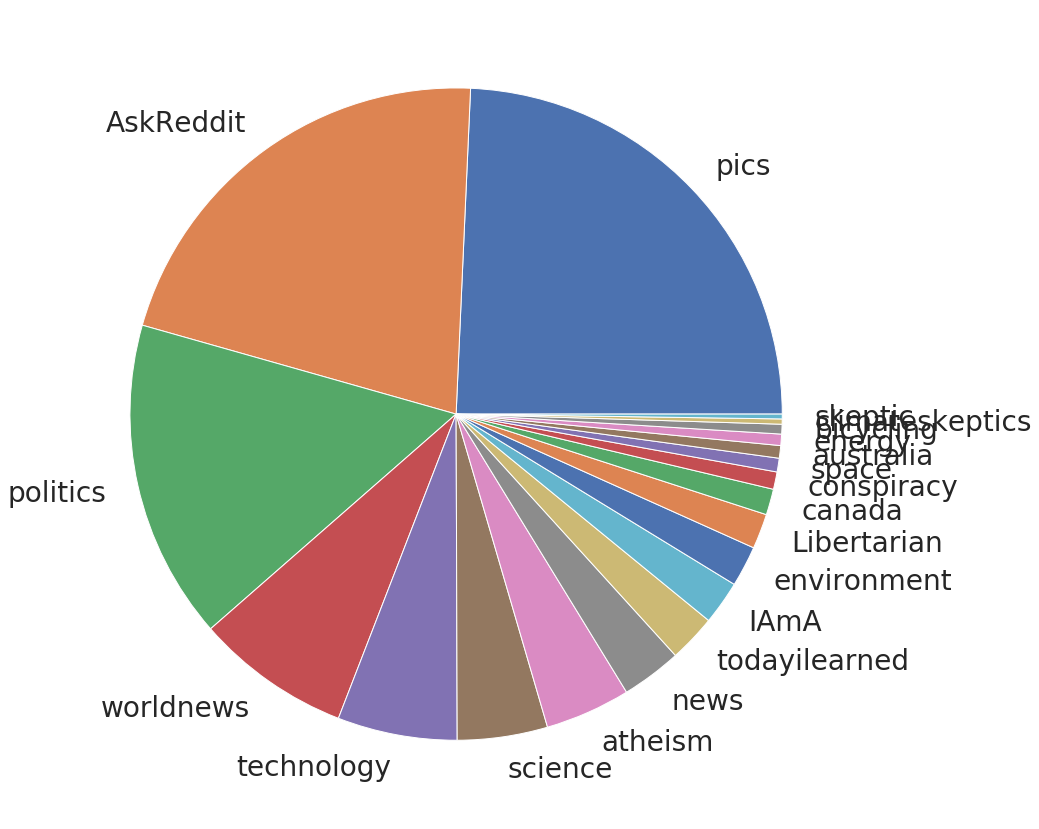

In [16]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0
ax = posts_with_words['subreddit'].value_counts()[:20].plot.pie(figsize=(15, 15),label='',
                                                           textprops={'fontsize': 28})